/home/steinbac/software/tifffile/0.8/python3/lib64/python3.4/site-packages/tifffile-0.8.0-py3.4-linux-x86_64.egg/tifffile/tifffile.py:263: UserWarning: failed to import the optional _tifffile C extension module.
Loading of some compressed images will be very slow.
Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "failed to import the optional _tifffile C extension module.\n"


(108, 1352, 532) (92, 1024, 512)


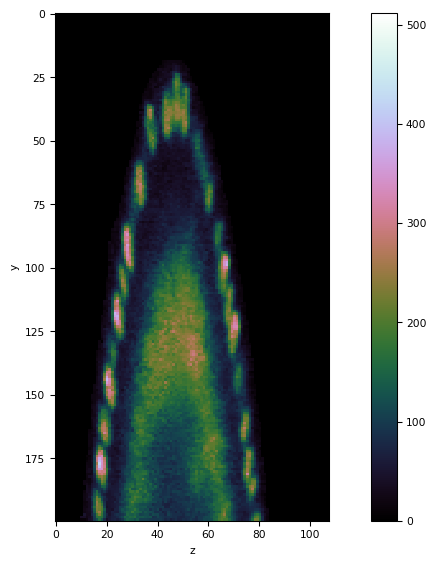

In [1]:
%matplotlib inline
import tifffile
import blosc
import numpy as np

blosc.set_nthreads(1)

royer1 = "/scratch/steinbac/sqeasy_data/xwing/droso-royer-may31-000005.tif"
xwingr = tifffile.imread(royer1)

haase1 = "/scratch/steinbac/sqeasy_data/xwing/000195-rhaase-20171129-fused-512x1024x92.tif"
xwingh = tifffile.imread(haase1)

smallr = xwingr[:,:200,:]
smallh = xwingh[:,:200,:]

sizes = {"smallr" : len(smallr.tobytes()), "smallh" : len(smallh.tobytes())}
print(xwingr.shape,xwingh.shape)
ax = tifffile.imshow(smallr[:,:,int(smallr.shape[-1]/2)].T)
ax[1].set_xlabel("z")
ax[1].set_ylabel("y")

# study of frame shuffle

- reorder frames along z along rising mean/median

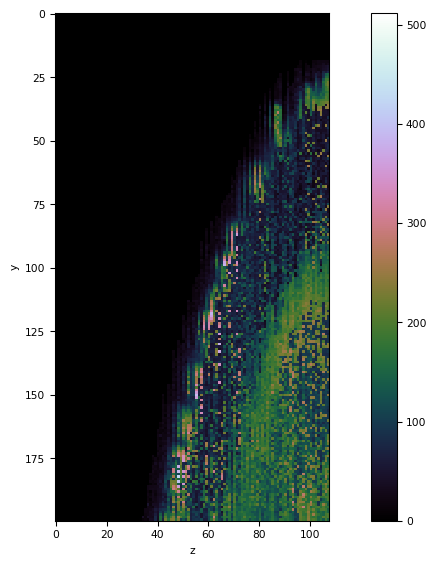

In [2]:
def frameline_shuffle(_data):
    
    if len(_data.shape) != 3:
        print("data is not 3D!")
        return _data
    
    sof = [] #sum_of_frame
    sol = [] #sum_of_lines
    
    for z in range(_data.shape[0]):
        sof.append(np.sum(_data[z,:,:]))
        sol.append([])
        
        for y in range(_data.shape[1]):
            sol[z].append(np.sum(_data[z,y,:]))
        
        
    assert len(sof) == _data.shape[0]
    assert len(sol[0]) == _data.shape[1]
    
    sorted_sof = sorted(sof)
    sorted_sol = [ sorted(v) for v in sol ]
        
    value = np.zeros_like(_data)
       
    for z in range(_data.shape[0]):
        src_z_index = sof.index(sorted_sof[z])
        for y in range(_data.shape[1]):
            src_y_index = sol[src_z_index].index(sorted_sol[src_z_index][y])
            value[z,y,:] = _data[src_z_index,src_y_index,:]
        
    return value

sorted_smallr = frameline_shuffle(smallr)
sorted_smallh = frameline_shuffle(smallh)

ax = tifffile.imshow(sorted_smallr[:,:,int(sorted_smallr.shape[-1]/2)].T)
ax[1].set_xlabel("z")
ax[1].set_ylabel("y")

In [3]:
import math
import time
import pandas as pd

strd = {blosc.BITSHUFFLE : "bitshuffle", 
        blosc.NOSHUFFLE : "none", 
        None : "none" , 
        blosc.SHUFFLE : "byteshuffle"}

def compress_list(datum,tag="",shufflemode = blosc.BITSHUFFLE, clevel = 5, engine="lz4"):
    
          
    start = time.time()
    compressed = blosc.compress(datum.tobytes(),shuffle=shufflemode,clevel=clevel,cname=engine)
    end = time.time()   
    value = [tag,
             blosc.nthreads,
             len(datum.tobytes()),
             len(compressed),
             end-start,
             engine,clevel,strd[shufflemode]]
    return value

blosc.set_nthreads(4)

results = pd.DataFrame(columns=['tag', 'nthreads', 'inbytes', 'outbytes', 'time_sec', 'engine', 'clevel', 'shuffle'])

counter = 0
results.loc[counter],counter = (compress_list(smallr,tag="smallr")), counter + 1
results.loc[counter],counter = (compress_list(smallh,tag="smallh")), counter + 1
results.loc[counter],counter = (compress_list(smallr,shufflemode=blosc.NOSHUFFLE,tag="smallr")), counter + 1
results.loc[counter],counter = (compress_list(smallh,shufflemode=blosc.NOSHUFFLE,tag="smallh")), counter + 1
results.loc[counter],counter = (compress_list(smallr,clevel=8,tag="smallr")), counter + 1
results.loc[counter],counter = (compress_list(smallh,clevel=8,tag="smallh")), counter + 1
results.loc[counter],counter = (compress_list(smallr,clevel=2,tag="smallr")), counter + 1
results.loc[counter],counter = (compress_list(smallh,clevel=2,tag="smallh")), counter + 1

results.loc[counter],counter = (compress_list(sorted_smallr,tag="smallr_sorted")), counter + 1
results.loc[counter],counter = (compress_list(sorted_smallh,tag="smallh_sorted")), counter + 1
results.loc[counter],counter = (compress_list(sorted_smallr,shufflemode=blosc.NOSHUFFLE,tag="smallr_sorted")), counter + 1
results.loc[counter],counter = (compress_list(sorted_smallh,shufflemode=blosc.NOSHUFFLE,tag="smallh_sorted")), counter + 1
results.loc[counter],counter = (compress_list(sorted_smallr,clevel=8,tag="smallr_sorted")), counter + 1
results.loc[counter],counter = (compress_list(sorted_smallh,clevel=8,tag="smallh_sorted")), counter + 1
results.loc[counter],counter = (compress_list(sorted_smallr,clevel=2,tag="smallr_sorted")), counter + 1
results.loc[counter],counter = (compress_list(sorted_smallh,clevel=2,tag="smallh_sorted")), counter + 1

print(results)

              tag nthreads   inbytes  outbytes  time_sec engine clevel  \
0          smallr        4  22982400   3789107  0.108393    lz4      5   
1          smallh        4  18841600   4464109  0.083570    lz4      5   
2          smallr        4  22982400   4864902  0.072871    lz4      5   
3          smallh        4  18841600  11415619  0.069103    lz4      5   
4          smallr        4  22982400   3647688  0.105791    lz4      8   
5          smallh        4  18841600   4362905  0.084212    lz4      8   
6          smallr        4  22982400   4007329  0.106156    lz4      2   
7          smallh        4  18841600   4608407  0.086671    lz4      2   
8   smallr_sorted        4  22982400   3816639  0.036939    lz4      5   
9   smallh_sorted        4  18841600   4449464  0.035519    lz4      5   
10  smallr_sorted        4  22982400   4866994  0.007265    lz4      5   
11  smallh_sorted        4  18841600  11240622  0.021219    lz4      5   
12  smallr_sorted        4  22982400  

In [4]:
blosc.set_nthreads(1)
st_results = pd.DataFrame(columns=['tag', 'nthreads', 'inbytes', 'outbytes', 'time_sec', 'engine', 'clevel', 'shuffle'])

counter = 0
st_results.loc[counter],counter  = compress_list(smallr,tag="smallr"), counter + 1
st_results.loc[counter],counter  = compress_list(smallh,tag="smallh"), counter + 1
st_results.loc[counter],counter  = compress_list(sorted_smallr,tag="smallr_sorted"), counter + 1
st_results.loc[counter],counter  = compress_list(sorted_smallh,tag="smallh_sorted"), counter + 1
st_results.loc[counter],counter  = compress_list(smallr,shufflemode=blosc.NOSHUFFLE,tag="smallr"), counter + 1
st_results.loc[counter],counter  = compress_list(smallh,shufflemode=blosc.NOSHUFFLE,tag="smallh"), counter + 1
st_results.loc[counter],counter  = compress_list(sorted_smallr,shufflemode=blosc.NOSHUFFLE,tag="smallr_sorted"), counter + 1
st_results.loc[counter],counter  = compress_list(sorted_smallh,shufflemode=blosc.NOSHUFFLE,tag="smallh_sorted"), counter + 1

st_results.loc[counter],counter  = compress_list(smallr,clevel=8,tag="smallr"), counter + 1
st_results.loc[counter],counter  = compress_list(smallh,clevel=8,tag="smallh"), counter + 1
st_results.loc[counter],counter  = compress_list(sorted_smallr,clevel=8,tag="smallr_sorted"), counter + 1
st_results.loc[counter],counter  = compress_list(sorted_smallh,clevel=8,tag="smallh_sorted"), counter + 1
st_results.loc[counter],counter  = compress_list(smallr,clevel=2,tag="smallr"), counter + 1
st_results.loc[counter],counter  = compress_list(smallh,clevel=2,tag="smallh"), counter + 1
st_results.loc[counter],counter  = compress_list(sorted_smallr,clevel=2,tag="smallh_sorted"), counter + 1
st_results.loc[counter],counter  = compress_list(sorted_smallh,clevel=2,tag="smallh_sorted"), counter + 1

In [5]:
def summary(cdic):
    max_label_size = max([ len(k) for k in cdic.keys()])
    
    
    print(("%"+str(max_label_size)+"s %20s %10s %10s %10s %8s %10s")%("","info","nthreads","inbytes","outbytes","ratio", "bw [MB/s]"))
    for (k,item) in cdic.items():
        
        ratio = item[0]/item[1]
        bw = item[0]/(1024.*1024.*item[2])
        print(("%"+str(max_label_size)+"s %20s %10i %10i %10i %8.2f %10.2f") % (k,item[-1],blosc.nthreads,item[0],item[1],ratio,bw))
            
def summarize(df):
    df["ratio"] = df["inbytes"]/df["outbytes"]
    df["bw_mb_per_s"] = df["inbytes"]/(1024*1024.*df["time_sec"])
    return df



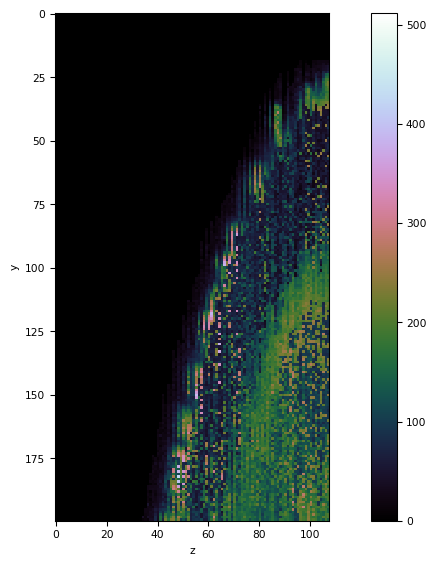

In [6]:
def global_frameline_shuffle(_data):
    
    if len(_data.shape) != 3:
        print("data is not 3D!")
        return _data
    
    gsol = [] #sum_of_frame
    sol = [] #sum_of_lines
    
    for z in range(_data.shape[0]):
        
        sol.append([])
        
        for y in range(_data.shape[1]):
            csum = np.sum(_data[z,y,:])
            sol[z].append(csum)
            gsol.append(csum)
    
    assert len(sol[0]) == _data.shape[1]
    assert len(gsol) == _data.shape[1]*_data.shape[0]
    #print(gsol)
    sorted_gsol = sorted(gsol)
    sorted_sol = [ sorted(v) for v in sol ]
        
    value = np.zeros_like(_data)
       
    counter = 0
    currentz = 0
    src_gsol_index = -1
    for lsum in sorted_gsol:
        currenti = gsol.index(lsum)
        if currenti == src_gsol_index:
            src_gsol_index += 1
        else:
            src_gsol_index = currenti
        
        src_z_index = math.floor(src_gsol_index / _data.shape[1])
        assert src_z_index <= _data.shape[0]
        src_y_index = src_gsol_index - (_data.shape[1]*src_z_index)
        #print(_data.shape,currentz,counter, lsum,"<-",src_z_index,src_y_index)
        value[currentz,counter,:] = _data[src_z_index,src_y_index,:]
        if counter > 0 and (counter % (_data.shape[1]-1) == 0):
            currentz += 1
            counter = 0
        else:
            counter += 1
        
    return value

gsmallr = global_frameline_shuffle(smallr)
gsmallh = global_frameline_shuffle(smallh)

ax = tifffile.imshow(sorted_smallr[:,:,int(gsmallr.shape[-1]/2)].T)
ax[1].set_xlabel("z")
ax[1].set_ylabel("y")

In [7]:
blosc.set_nthreads(4)

counter = len(results.index)
print(compress_list(gsmallr,tag="gsmallr"),results.shape)
results.loc[counter],counter = compress_list(gsmallr,tag="gsmallr"), counter + 1
results.loc[counter],counter = compress_list(gsmallh,tag="gsmallh"), counter + 1
results.loc[counter],counter = compress_list(gsmallr,shufflemode=blosc.NOSHUFFLE,tag="gsmallr"), counter + 1
results.loc[counter],counter = compress_list(gsmallh,shufflemode=blosc.NOSHUFFLE,tag="gsmallh"), counter + 1
results.loc[counter],counter = compress_list(gsmallr,clevel=8,tag="gsmallr"), counter + 1
results.loc[counter],counter = compress_list(gsmallh,clevel=8,tag="gsmallh"), counter + 1
results.loc[counter],counter = compress_list(gsmallr,clevel=2,tag="gsmallr"), counter + 1
results.loc[counter],counter = compress_list(gsmallh,clevel=2,tag="gsmallh"), counter + 1

blosc.set_nthreads(1)
counter = len(st_results.index)
st_results.loc[counter],counter = compress_list(gsmallr,tag="gsmallr"), counter + 1
st_results.loc[counter],counter = compress_list(gsmallh,tag="gsmallh"), counter + 1
st_results.loc[counter],counter = compress_list(gsmallr,shufflemode=blosc.NOSHUFFLE,tag="gsmallr"), counter + 1
st_results.loc[counter],counter = compress_list(gsmallh,shufflemode=blosc.NOSHUFFLE,tag="gsmallh"), counter + 1
st_results.loc[counter],counter = compress_list(gsmallr,clevel=8,tag="gsmallr"), counter + 1
st_results.loc[counter],counter = compress_list(gsmallh,clevel=8,tag="gsmallh"), counter + 1
st_results.loc[counter],counter = compress_list(gsmallr,clevel=2,tag="gsmallr"), counter + 1
st_results.loc[counter],counter = compress_list(gsmallh,clevel=2,tag="gsmallh"), counter + 1


['gsmallr', 4, 22982400, 3857927, 0.06407999992370605, 'lz4', 5, 'bitshuffle'] (16, 8)


In [8]:
fresults = summarize(results)
cols = fresults.columns
these = [ item for item in cols if not (item.count('byte') or item.count('time')) ]
print(fresults[these])
st_results['nthreads'] = 1
fst_results = summarize(st_results)

print(fst_results[these])


              tag nthreads engine clevel     shuffle    ratio bw_mb_per_s
0          smallr        4    lz4      5  bitshuffle  6.06539     202.207
1          smallh        4    lz4      5  bitshuffle  4.22069     215.013
2          smallr        4    lz4      5        none  4.72412     300.773
3          smallh        4    lz4      5        none  1.65051     260.027
4          smallr        4    lz4      8  bitshuffle  6.30054     207.179
5          smallh        4    lz4      8  bitshuffle  4.31859     213.376
6          smallr        4    lz4      2  bitshuffle  5.73509     206.467
7          smallh        4    lz4      2  bitshuffle  4.08853     207.321
8   smallr_sorted        4    lz4      5  bitshuffle  6.02163     593.347
9   smallh_sorted        4    lz4      5  bitshuffle  4.23458     505.896
10  smallr_sorted        4    lz4      5        none  4.72209     3017.05
11  smallh_sorted        4    lz4      5        none  1.67621     846.813
12  smallr_sorted        4    lz4     